In [ ]:
import random
import copy
import math
import itertools
from collections import defaultdict
import numpy as np
import pandas as pd
import numpy.linalg as npl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import json
from sklearn.svm import LinearSVC
from collections import defaultdict
import cvxpy as cp
from data_utils_m import *
from nxt_token_solver_m import W_svm_solver_cvxpy, R_solver, Tarjan
from itertools import zip_longest

from base_nonlinear import MLayerAttn
from utils import *
from train_utils_m import train_W, train_Wfin
from visualizer import show_corr, show_norm_diff, show_proj_corr, show_attn_probs, show_attn_probs_neg

import time
from google.colab import files
import os

## Parameters

In [ ]:
"""
1. numeric settings
"""
K = 7  # Vocabulary size
L = 8  # Number of arrows to randomly choose
T = 4 # the length of sequence (not include the next token)
n = 10 # Number of sequence in each dataset
d = 4 # dim of embedding token

"""
2. data parameters
"""
token_choice = 'random' # ['equi-corr', 'ortho', 'random']
cls_choice = 'iden'
same_last_token = False
rep_seq = False
check_label = True
check_asyc = False

toy_case = False
batch_toy = False
custom_initialize = False

separa = False # Whether the last token can map to different labels


"""
3. attention model parameters
"""
loss_type = 'nll' # ['ce', 'nll', 'corr', 'lsq2', 'mse']

nlayer = 1 # number of layers

skip = False # add skip connection to every attention output
layer_norm = False # add layer norm to every attention output
avg_norm = False
factorize_w = False # use W or (Q, K)

initialize_w = 'default' # 'default': random initialization, 'zero': initialize W as zero matrix, 'random': random initialization with varying variance
strong_default = False
initialize_wfin = 'zero'

reg_wfin = 0 # regularization for W_fin
# W_fin must be initialized as zero matrix

lr = 0.01

epochs = 1
ITN = 6000

norm_grad = True

Wi_list = np.zeros((nlayer, ITN, d, d))
sol_cvx_list = np.zeros((nlayer, d, d))
Wi_norm_list = np.zeros((nlayer, epochs, ITN))

dlist = [8]

attn_probs = np.zeros((len(dlist), epochs, ITN))
corr_list = np.zeros((len(dlist), 2, epochs, ITN))

"""
customize_seed
"""
def customize_seed(seed): # {topic 1: seed = 42, topic 2: seed = 99, combine: seed = 22}
    random.seed(seed) # select_arrows_for_each_token() and find_and_add_missing_relationships()
    np.random.seed(seed) # step 2.3 of generate_sequence_from_tpgs()
    torch.manual_seed(seed)

## Part 1: Generate Theoretical TPGs

### Step 1. Define K and L

### Step 2. Randomly choose  𝐿  (# of arrows) couples for each token

In [ ]:
# For each token k = 1, 2, ..., K, randomly select L arrows involving k
def select_arrows_for_each_token(K, L):

    # Get all possible directed edges (ei -> ej where ei != ej)
    all_possible_edges = [(i, j) for i, j in itertools.permutations(range(K), 2)]

    initial_tpgs = {}

    for k in range(K):
        # Select edges where token k is involved (either as the source or destination)
        valid_edges = [edge for edge in all_possible_edges if edge[0] == k or edge[1] == k]

        # Ensure that token k is included in the TPG
        selected_edges = random.sample(valid_edges, 1)  # Pick one edge that includes token k

        # Now pick the rest of the L-1 arrows from all possible edges (can include or exclude token k)
        other_edges = [edge for edge in all_possible_edges if edge not in selected_edges]
        selected_edges += random.sample(other_edges, L - 1)  # Pick (L-1) arrows randomly

        initial_tpgs[k] = selected_edges
    return initial_tpgs

### Step 3. Add missing arrows from token k to all tokens based on its own TPG

In [ ]:
def forcing_reached_by_k(k, initial_tpgs):

    initial_tpg_k = initial_tpgs[k]
    theor_tpg_k = initial_tpg_k.copy()

    # Step 1: find all unique tokens in tpg(k)
    unique_tokens = {arrow[0] for arrow in initial_tpg_k}.union({arrow[1] for arrow in initial_tpg_k})

    # Step 2: determine tokens that are not reached by the token k
    reachable_tokens = {arrow[1] for arrow in initial_tpg_k if arrow[0] == k}  # Tokens the key currently points to
    missing_tokens = unique_tokens - reachable_tokens - {k}  # Exclude the key itself

    # Step 3: add missing arrows from `k` to ensure reachability to all tokens in unique_tokens
    new_arrows = [(k, target) for target in missing_tokens]
    theor_tpg_k.extend(new_arrows)

    return theor_tpg_k

### Step 4.Theoretical TPGs based on Step 3.

In [ ]:
def get_theor_tpgs_new(K, L):

    theor_tpgs = {k:[] for k in range(K)} # save the theoretical TPGs
    theor_Gs = {k: nx.DiGraph() for k in range(K)} # save the theoretical TPG graph

    initial_tpgs = select_arrows_for_each_token(K,L) # randomly select L arrows out of K(K-1)

    for k in range(K):
        theor_tpg_k = forcing_reached_by_k(k, initial_tpgs)
        theor_tpgs[k] = theor_tpg_k

        for i in range(len(theor_tpg_k)):
            edge = theor_tpg_k[i]
            theor_Gs[k].add_edge(edge[0], edge[1])

    return initial_tpgs, theor_tpgs, theor_Gs

In [ ]:
# For TPGs visualization if needed
def draw_graphs(k, Graphs, topic, TPG_type): # k = token ID
    plt.figure(figsize=(4, 3))
    pos = nx.spring_layout(Graphs)  # Position nodes using the spring layout

    nx.draw(Graphs[k], pos, with_labels=True, arrows=True, node_size=500, node_color='lightblue', font_size=7, font_weight='bold')
    plt.title(f'{topic} {TPG_type}: Token {k}')
    plt.grid(False)
    plt.show()


### Step 5. Generate TPG combining two topics

In [ ]:
# Combine two TPGs for each token
def combine_tpgs(tpgs_group_1, tpgs_group_2):
    combined_tpgs = {}
    for k in range(K):
        combined_tpgs[k] = tpgs_group_1[k] + [edge for edge in tpgs_group_2[k] if edge not in tpgs_group_1[k]]

    return combined_tpgs

In [ ]:
# Generate theoretical tpgs for the combination of two topics
def get_theor_tpgs_cb_new(theor_tpgs_1, theor_tpgs_2):

    theor_tpgs = {k:[] for k in range(K)} # save the theoretical TPGs
    theor_Gs = {k: nx.DiGraph() for k in range(K)} # save the theoretical TPG graph

    initial_tpgs = combine_tpgs(theor_tpgs_1, theor_tpgs_2)

    for k in range(K):
        theor_tpg_k = forcing_reached_by_k(k, initial_tpgs)
        theor_tpgs[k] = theor_tpg_k

        for i in range(len(theor_tpg_k)):
            edge = theor_tpg_k[i]
            theor_Gs[k].add_edge(edge[0], edge[1])

    return initial_tpgs, theor_tpgs, theor_Gs

## Part 2: Generate data for each topic

### Step 6. Decide the length of sequence T

### Step 7. Generate sequence for each topic

In [ ]:
def generate_sequence_from_tpgs(theor_tpgs, T):
    sequence_length = T  # Sequence length is T = 4

    # Step 1: Randomly choose the last token k (e_T)
    last_token_k = random.randint(0, K-1)  # Choose a random token as the last one (0 <= k <= K-1)

    tpg_for_k = theor_tpgs[last_token_k]  # Select the TPG for the last token k


    # Step 2: Randomly choose the next token e_{T+1} in the selected TPG
    ## 2.1 find e_j that have arrows coming from the last token k
    outgoing_edges = [edge for edge in tpg_for_k if edge[0] == last_token_k]
    destination_nodes = [edge[1] for edge in outgoing_edges]
    destination_nodes.append(last_token_k)

    ## 2.2 count the arrows pointing to each destination node (include e_j itself)
    destination_counts = {node: 1 for node in destination_nodes} # start from 1: including e_j itself
    for edge in tpg_for_k:
        if edge[1] in destination_counts:
            destination_counts[edge[1]] += 1

    ## 2.3 randomly choose the next token e_{T+1} based on weighted prob
    total_count = sum(destination_counts.values())
    prob = [count / total_count for count in destination_counts.values()]

    next_token = np.random.choice(list(destination_counts.keys()), p=prob)


    # Step 3: Randomly choose the location of the next token in the input sequence
    available_positions = list(range(sequence_length - 1))  # Positions: 0, 1, 2, 3
    next_token_position_input = random.choice(available_positions)  # Choose a position for e_{T+1}

    input_sequence = [None] * (sequence_length - 1) # Initialize the input sequence with None
    input_sequence.append(last_token_k)
    input_sequence[next_token_position_input] = next_token  # Place e_{T+1} in the sequence


    # Step 4: Randomly choose the rest of the tokens that have arrows to the next token in the TPG
    remaining_positions = [pos for pos in available_positions if pos != next_token_position_input]

    # Find tokens that have arrows pointing to the chosen next token
    possible_previous_tokens = [edge[0] for edge in tpg_for_k if edge[1] == next_token]
    possible_previous_tokens.append(next_token) # next_token can also be chosen as the rest of token

    if len(possible_previous_tokens) == 0:
        raise ValueError(f"No available nodes in the TPG for token {last_token_k}.")

    # Randomly choose tokens for the remaining positions
    for pos in remaining_positions:
        token = random.choice(possible_previous_tokens)
        input_sequence[pos] = token

    return input_sequence, next_token

### Step 8. Repeat $n$ times to generate data for topic 1

In [ ]:
# Generate data set with N sequences based on the updated TPG
def generate_data(theor_tpgs, n, T):

    results = []
    for i in range(n):
        sequence, next_token = generate_sequence_from_tpgs(theor_tpgs, T)
        results.append((sequence, next_token))

    return results

### Step 9. Generate data for topic 2

### Step 10. Get the dataset for combining two topics
Simply union data_1 and data_2
```
data_combine = data_topic_1 + data_topic_2
```

### NOTE: Get empirical tpgs

In [ ]:
def get_empir_tpgs(empir_data):
    seq_classified = {k: [] for k in range(K)}  # save the data group by the last token ID

    empir_tpgs = {k:[] for k in range(K)} # save the edges based on the generated data
    empir_Gs = {k: nx.DiGraph() for k in range(K)} # save the empirical TPG

    for seq in empir_data:
        k = seq[0][-1]
        seq_classified[k].append(seq)

    for k, seqs in seq_classified.items():
        for seq in seqs:
            tokens = seq[0]
            for i in range (len(tokens)):
                if tokens[i] != seq[-1]:
                    edge = (tokens[i], seq[-1])
                    if edge not in empir_tpgs[k]:
                        empir_tpgs[k].append(edge) # from every input token to the next token
                        empir_Gs[k].add_edge(tokens[i], seq[-1])
    return seq_classified, empir_tpgs, empir_Gs

## Part 3: Calculate $W^{svm}$ and $W(\tau)$

### Step 11. Calculate $W_1^{svm}, W_2^{svm}, W^{svm}$ by using $\{X^1_i, y^1_i\}_{i=1}^N$, $\{X^2_i, y^2_i\}_{i=1}^N$, and $\{X_i, y_i\}_{i=1}^N$

#### 11.1 Get vocabulary and dictionary

In [ ]:
def get_vocab_dict(token_choice, K, d, rho = 0.5):

    if token_choice == 'ortho':

        assert K <= d

        A = torch.randn(d, d).double()

        Vocab = torch.linalg.qr(A.T)[0][:K] # [K, d]

        tolerance = 1e-6  # Adjust as needed for your precision requirements

        for i in range(K):
            for j in range(i + 1, K):
                dot_product = torch.dot(Vocab[i], Vocab[j]).item()
                if abs(dot_product) < tolerance:
                    continue
                else:
                    print(f"Dot product of row {i} and row {j}: {dot_product} (not within tolerance)")

    elif token_choice == 'equi-corr':
        # Generate a set of K - 1 vectors with correlation rho
        A = torch.randn(d, d).double()
        C = torch.linalg.qr(A)[0][:K] # [K, d]
        Vocab = torch.zeros((K - 1, d)).double()
        for i in range(0, K - 1):
            Vocab[i] = math.sqrt(rho) * C[0] + math.sqrt(1 - rho) * C[i + 1]

        for i in range(K - 1):
            assert Vocab[i].norm() - 1 < 1e-5
            for j in range(i + 1, K - 1):
                # Calculate the correlation between Vocab[i] and Vocab[j]
                assert torch.abs(Vocab[i].dot(Vocab[j])) - rho < 1e-5
        K = K - 1
    else:
        Vocab = torch.randn(K, d).double()
        Vocab = torch.nn.functional.normalize(Vocab, dim = -1)
    dict_token = {i: Vocab[i] for i in range(K)} # used to find the index of the token

    EE_T_inv = torch.inverse(Vocab @ Vocab.T) # shape [K,K]
    pseudo_Vocab = (Vocab.T @ EE_T_inv).T


    return Vocab, dict_token, pseudo_Vocab

#### 11.2 Get other input parameters
- Part 1: X
- Part 2: idx_token
- Part 3: idx_z
- Part 4: C_alpha
- Part 5: scc_klst
- Part 6: z, the last token of each sequence
- Part 7: get adj_mat

In [ ]:
# Part 1: X, embedding word for each sequence
def get_X(data, dict_token):

      input_X = []

      for item in data:
          key_sequence = item[0]  # Extract the token ID in each sequence
          values = [dict_token[key].tolist() for key in key_sequence]  # Get the corresponding values from dict_token
          input_X.append(values)

      input_X = torch.tensor(input_X)
      X = input_X.double() #dtype: torch.float64
      return X

# Part 2: idx_token, token ID for each input sequence
def get_idx_token(data):

    data_input_idx = [item[0] for item in data] # extract id of input sequence
    idx_token = torch.tensor(data_input_idx) # change list to tensor

    return idx_token

# Part 3: idx_z, the last token ID for each sequence
def get_idx_z(data):
      idx_z = []

      for i in range(len(data)):
          idx_zi = data[i][0][-1]
          idx_z.append(idx_zi)

      idx_z = torch.tensor(idx_z)
      return idx_z

# Part 4: C/C_alpha, the next token ID for each sequence
def get_C_alpha(data):
    C = []
    for i in range(len(data)):
      C_i = data[i][-1]
      C.append(C_i)

    C_alpha = torch.tensor(C)

    return C_alpha

# Part 5: get scc_klst: scc for each TPG
def get_scc_klst (idx_token, C_alpha):
    scc_klst = []

    for k in range(K):
        tarjan_solver = Tarjan(K)
        mask = idx_token[:, -1] == k
        cnt = torch.sum(mask).item()
        if cnt == 0:
            scc_klst.append([])
            continue

        tarjan_solver.initialize(idx_token[mask], C_alpha[mask])
        tarjan_solver.run()
        #tarjan_solver.output()
        scc_lst = tarjan_solver.get_scc()
        scc_klst.append(scc_lst)

    return scc_klst

# Part 6: z, the last token of each sequence
def get_z(data, dict_token, toy_case, batch_toy):

    X = get_X(data, dict_token)
    if toy_case and batch_toy:
        input_z = []
        for i in range(len(X)):
            zi = X[i][-1]
            input_z.append(zi)
        input_z = torch.stack(input_z)
        assert input_z.shape == (n, d)
    else:
        input_z = X[:, -1].unsqueeze(1) # [n, d]

    z = input_z.double() #dtype: torch.float64
    return z

# Part 7: get adj_mat (one of the input parameters of W_svm_solver_cvxpy)
def get_adjacency_matrix(token_choice, idx_token, C_alpha):
    if token_choice == 'equi-corr':
            adj_mat = np.zeros((K -1, K - 1, K -1)) # #of distinct last tokens, |ID|, |ID|
    else:
        adj_mat = np.zeros((K , K , K )) # #of distinct last tokens, |ID|, |ID|

    for i in range(len(idx_token)):
        for j in range(len(idx_token[i])):
            if C_alpha[i] == idx_token[i][j]:
                continue
            adj_mat[idx_token[i][-1], C_alpha[i], idx_token[i][j]] = 1

    return adj_mat

#### 11.3 Calculate $W^{svm}_1$, $W^{svm}_2$, and $W^{svm}$

In [ ]:
def get_input_paras(data, dict_token):

      X = get_X(data, dict_token)
      idx_token = get_idx_token (data)
      z = get_z(data, dict_token, toy_case, batch_toy)
      idx_z = get_idx_z(data)
      C_alpha = get_C_alpha(data)
      scc_klst = get_scc_klst(idx_token, C_alpha)
      adj_mat = get_adjacency_matrix (token_choice = token_choice, idx_token = idx_token, C_alpha = C_alpha)


      return X, idx_token, z, idx_z, C_alpha, scc_klst, adj_mat


### Step 12. Generate $W_1(\tau)$, $W_2(\tau)$, $W(\tau)$, where $\tau = 1, ...., ITN$

#### Step 12.1: self-attention model

In [ ]:
model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                        identity_W=False, identity_V = True,
                        factorize_W = factorize_w, init = initialize_w,
                        skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
                ).double()

#### Step 12.2: $W$ training - train_W()

In [ ]:
# Required input parameters for training
def get_para_list (factorize_w, layer_norm, avg_norm):

      if factorize_w:
            parameter_list = [model.query1.weight, model.query2.weight, model.key1.weight, model.key2.weight]
      else:
          parameter_list = [m.weight for m in model.qklist]

      if layer_norm and not avg_norm:
          parameter_list += [model.ln.weight, model.ln.bias]

      return parameter_list

### Step 13. Correlation coefficient between $W^{svm}$ and $W(\tau)$

- Get correlation coefficient
- Visualize Correlation Coefficient and Iteration


# Part 4: Save Training Results

In [ ]:
def before_save_results(df_results):

    col_dict_tensor = ['dictionary', 'test_X_12cb', 'test_z_12cb']
    col_dict_array = ['W_svm_12cb', 'W_tau_12cb', 'last_W_12cb']
    col_list = ['correlation_1', 'correlation_2', 'correlation_cb']
    col_dict = ['empir_TPG_12cb', 'training_data', 'SCC_12cb', 'testing_data', 'testing_data_new', 'test_SCC_12cb']
    col_tensor = ['pseudo_Vocab']

    df_results_save = df_results.copy()
    for col in df_results_save.columns:

        if col in col_dict_tensor or col in col_dict_array:
            for i in df_results.index:
                for key, value in df_results_save[col][i].items():
                    if type(value) != list:
                        df_results_save[col][i][key] = value.tolist()

        elif col in col_tensor:
            for i in df_results.index:
                if type(df_results_save.loc[i, col]) != list:
                    df_results_save.at[i, col] = df_results_save.at[i, col].tolist()

        else:
            df_results_save[col] = df_results_save[col]

    return df_results_save

def after_open_results(df_results_open):

    col_dict_tensor = ['dictionary', 'test_X_12cb', 'test_z_12cb']
    col_dict_array = ['W_svm_12cb', 'W_tau_12cb', 'last_W_12cb']
    col_list = ['correlation_1', 'correlation_2', 'correlation_cb']
    col_dict = ['empir_TPG_12cb', 'training_data', 'SCC_12cb', 'testing_data', 'testing_data_new', 'test_SCC_12cb']
    col_dict_str = ['dictionary']
    col_tensor = ['pseudo_Vocab']
    for col in df_results_open.columns:

        if df_results_open[col].dtype == 'object' and col != 'token_choice':

            for i in df_results_open.index:

                if col in col_dict_tensor:
                    for key, value in df_results_open[col][i].items():
                        if type(value) != torch.tensor:
                            df_results_open[col][i][key] = torch.tensor(df_results_open[col][i][key], dtype=torch.float64)
                if col in col_dict_str:
                    df_results_open.at[i, col] = {int(key): value for key, value in df_results_open.at[i, col].items()}

                if col in col_dict_array:
                    for key, value in df_results_open[col][i].items():
                        if type(value) != np.ndarray:
                            df_results_open[col][i][key] = np.array(df_results_open[col][i][key])

                if col in col_tensor:
                    if type(df_results_open.loc[i, col]) != torch.tensor:
                        df_results_open.at[i, col] = torch.tensor(df_results_open.at[i, col], dtype=torch.float64)
        else:
            df_results_open[col] = df_results_open[col]

    return df_results_open

# "Training Only": Integration of Part 1 - Part 4

In [ ]:
start_time = time.time()

In [ ]:
epochs = 25

K = 10 # Vocabulary size
L = 4 # Number of arrows to randomly choose
d = 16 # dim of embedding token
T = 4 # the length of sequence (not include the next token)
test_T = 8 # generate the another group of test data for having repeated tokens in case 4
token_choice = 'random'
ITN = 8000
lr = 0.01
part = 2 # each part with 25 epochs, then combine 2 parts with the same parameter settings

In [ ]:
inspect = False
use_double = True
batch = True
loss_type = 'nll'
separa = False
use_scc = True
rep_seq = False
check_label = True
cls_choice = 'iden'
check_asyc = False
same_last_token = False
toy_case = False
batch_toy = False
custom_initialize = False
nlayer = 1
skip = False
layer_norm = False
avg_norm = False
factorize_w = False
initialize_w = 'default'
strong_default = False
initialize_wfin = 'zero'
reg_wfin = 0
norm_grad = True

In [ ]:
"""
Section 1. Get W^{svm} and W(\tau) for each data

"""
dlist = [8]
di = len(dlist) -1
initial_n = 100  # Number of sequence in each dataset

training_datasets = ['data_topic_1', 'data_topic_2', 'data_combine']
testing_datasets = ['test_topic_1', 'test_topic_2', 'test_combine']

attn_probs_values = {}
Wi_norm_list_values = {}
dict_token_epochs = {}

# for training data
data_epochs = {}
X_epochs = {}
z_epochs = {}
scc_klst_epochs = {}

# for testing data
test_data_epochs_T = {}
test_data_epochs_test_T = {}


# training results
last_W_epochs = {} # save last W(\tau) of each epoch
sol_cvx_list_epochs = {} # save the W^{svm} of each epoch
W_tau_epochs = {} # save W(\tau) for each epoch
W_svm_epochs = {}
corr_list_values = {} # save correlation results for each epoch

theor_tpgs_epochs = {}  # save theoretical tpgs (before generating input data)
empir_tpgs_epochs ={} # save empirical tpgs (based on the genereated input data)
theor_graph_epochs = {} # save gragh of theoretical tpgs
empir_graph_epochs = {} # save gragh of empirical tpgs

for data in training_datasets:
    attn_probs_values[data] = np.zeros((len(dlist), epochs, ITN))
    corr_list_values[data] = np.zeros((len(dlist), 2, epochs, ITN))
    Wi_norm_list_values[data] = np.zeros((nlayer, epochs, ITN))


ei = 0
results = []
while ei < epochs:
    n = initial_n
    print("\n********************************************")
    print("Current epoch:", ei)

    # ============ Part 1: generate Theoretical TPG for topic 1, topic 2, and combination ============
    initial_tpgs_1, theor_tpgs_1, theor_Gs_1 = get_theor_tpgs_new(K,L) # topic 1
    initial_tpgs_2, theor_tpgs_2, theor_Gs_2 = get_theor_tpgs_new(K,L) # topic 2

    initial_tpgs_cb, theor_tpgs_cb, theor_Gs_cb = get_theor_tpgs_cb_new(theor_tpgs_1,theor_tpgs_2) # topic combine

    theor_tpgs_epochs[ei] = {
        'data_topic_1': theor_tpgs_1,
        'data_topic_2': theor_tpgs_2,
        'data_combine': theor_tpgs_cb
        }

    theor_graph_epochs[ei] = {
        'data_topic_1': theor_Gs_1,
        'data_topic_2': theor_Gs_2,
        'data_combine': theor_Gs_cb
        }


    # ============ Part 2: generate data and get input paras for topic 1, topic 2, and combination ============
    ## 2.1 get vocabulary and dict_token
    Vocab, dict_token, pseudo_Vocab = get_vocab_dict(token_choice = token_choice, K = K, d = d)


    dict_token_epochs[ei] = dict_token

    ## 2.2 generate training data
    data_topic_1 = generate_data(theor_tpgs_1, n, T) # topic 1
    data_topic_2 = generate_data(theor_tpgs_2, n, T) # topic 2
    data_combine = data_topic_1 + data_topic_2 # combine

    data_epochs[ei] = {
        'data_topic_1': data_topic_1,
        'data_topic_2': data_topic_2,
        'data_combine': data_combine
        }

    ## 2.3 Empirical TPG based on the input data
    seq_classified_1, empir_tpgs_1, empir_Gs_1 = get_empir_tpgs(data_topic_1) # topic 1
    seq_classified_2, empir_tpgs_2, empir_Gs_2 = get_empir_tpgs(data_topic_2) # topic 2
    seq_classified_cb, empir_tpgs_cb, empir_Gs_cb = get_empir_tpgs(data_combine) # combination

    empir_tpgs_epochs[ei] = {
        'data_topic_1': empir_tpgs_1,
        'data_topic_2': empir_tpgs_2,
        'data_combine': empir_tpgs_cb
        }

    empir_graph_epochs[ei] = {
        'data_topic_1': empir_Gs_1,
        'data_topic_2': empir_Gs_2,
        'data_combine': empir_Gs_cb
        }

    ## 2.4 Generate test data based on the empirical TPG
    # test data with the T = 4
    test_topic_1 = generate_data(empir_tpgs_1, n, T)
    test_topic_2 = generate_data(empir_tpgs_2, n, T)
    test_combine = test_topic_1 + test_topic_2

    test_data_epochs_T[ei] = {
        'test_topic_1': test_topic_1,
        'test_topic_2': test_topic_2,
        'test_combine': test_combine
        }

    # test data with the test_T = 8
    test_topic_1_new = generate_data(empir_tpgs_1, n, test_T)
    test_topic_2_new = generate_data(empir_tpgs_2, n, test_T)
    test_combine_new = test_topic_1_new + test_topic_2_new
    test_data_epochs_test_T[ei] = {
        'test_topic_1': test_topic_1_new,
        'test_topic_2': test_topic_2_new,
        'test_combine': test_combine_new
        }

    # ============ Part 3: Calculate W^{svm} and W(\tau) for each data ============

    ## 3.1 input parameters needed
    # Create dictionaries to store the returned values
    X_values = {}
    idx_token_values = {}
    z_values = {}
    idx_z_values = {}
    C_alpha_values = {}
    scc_klst_values = {}
    adj_mat_values = {}
    w_dir_values = {}
    sol_cvx_list_values = {}
    Wi_list_values = {}
    Wi_list_save = {}
    last_W_tau_values = {}
    parameter_list = {}

    for data in training_datasets:
        if data == 'data_combine':
            n = 2*initial_n
        else:
            n = initial_n

        X, idx_token, z, idx_z, C_alpha, scc_klst, adj_mat = get_input_paras(eval(data), dict_token)

        X_values[data] = X
        idx_token_values[data] = idx_token
        z_values[data] = z
        idx_z_values[data] = idx_z
        C_alpha_values[data] = C_alpha
        scc_klst_values[data] = scc_klst
        adj_mat_values[data] = adj_mat

        ## 3.1 get W^{svm} for each data (w_dir_values[data] and sol_cvx_list_values[data][0])

        w_dir_values[data] = W_svm_solver_cvxpy(Vocab, n, d, idx_z_values[data], idx_token_values[data],
                                                    C_alpha_values[data], onetoken = False, wfin = False,
                                                    adj_mat = adj_mat_values[data], scc_lst = scc_klst_values[data])

        sol_cvx_list_values[data] = np.zeros((nlayer, d, d))
        sol_cvx_list_values[data][0] =  normalize_sol(w_dir_values[data]) # normalized w_dir

        if np.all(sol_cvx_list_values[data][0] == 0):
            continue

        ## 3.2 calculate W(\tau)
        model = MLayerAttn(d, regress = True, n_layer = nlayer, dim_t = T,
                    identity_W=False, identity_V = True,
                    factorize_W = factorize_w, init = initialize_w,
                    skip = skip, layer_norm = layer_norm, avg_norm = avg_norm,
            ).double()

        parameter_list = get_para_list(factorize_w, layer_norm, avg_norm) # general_para_1

        optimizer = torch.optim.SGD(parameter_list, lr=lr, ) # general_para_2

        Wi_list_values[data] = np.zeros((nlayer, ITN, d, d)) # initialize Wi_list before training
        Wi_list_save[data] = np.zeros((nlayer, ITN // 8, d, d)) # initialize Wi_list for saving

        model = train_W(model, X_values[data], idx_token_values[data], z_values[data], token_choice, cls_choice, Vocab,
                        C_alpha_values[data], nlayer, n, K, di, ei, ITN, toy_case, batch_toy, scc_klst,
                        loss_type, optimizer, norm_grad, parameter_list,
                        Wi_list = Wi_list_values[data], attn_probs = attn_probs_values[data], Wi_norm_list = Wi_norm_list_values[data],
                        )

        ## 3.3 get correlation between W^{svm} and each W(\tau) (\tau = 1, 2, ..., ITN)
        for it in range(ITN):
                    Wi_list_values[data][0, it] /= np.linalg.norm(Wi_list_values[data][0, it])
                    if it % 8 == 0:
                        Wi_list_save[data][0, it // 8] = Wi_list_values[data][0, it]
                    if not separa:
                        corr_list_values[data][di, 0, ei, it] = Wi_list_values[data][0, it].reshape(-1).dot(sol_cvx_list_values[data][di].reshape(-1))


        last_W_tau_values[data] = Wi_list_values[data][0, ITN-1]

        print("For", data, "correlation of W and Wsvm: ", corr_list_values[data][di, 0, ei, -1])
        print("----------------------------")


    X_epochs[ei] = X_values
    z_epochs[ei] = z_values
    sol_cvx_list_epochs[ei] = sol_cvx_list_values
    scc_klst_epochs[ei] = scc_klst_values
    W_tau_epochs[ei] = Wi_list_values # shape (nlayer, ITN, d, d)
    last_W_epochs[ei] = last_W_tau_values

    # ============ Part 4: Save training results of each epoch ============

    row_ei = {'current_epoch': ei, 'K': K, 'L': L, 'd': d, 'T': T, 'token_choice': token_choice, '#_seqs_epoch': initial_n, # parameters
              'empir_TPG_12cb': empir_tpgs_epochs[ei], # empir_TPGs all (topic_1, topic_2, combine)
              'dictionary': dict_token, # dictionary
              'pseudo_Vocab': pseudo_Vocab, # pseudo_Vocab
              'training_data': data_epochs[ei], # train data
              'SCC_12cb': scc_klst_values,
              'testing_data': test_data_epochs_T[ei], # test data with T = 4
              'testing_data_new': test_data_epochs_test_T[ei], # test data with test_T = 8
              'W_svm_12cb': sol_cvx_list_values, # W_svm all (topic_1, topic_2, combine)
              'W_tau_12cb': Wi_list_save, # W_tau every 8
              'last_W_12cb': last_W_tau_values,
              'correlation_1': corr_list_values['data_topic_1'][di, 0, ei, :].tolist(),
              'correlation_2': corr_list_values['data_topic_2'][di, 0, ei, :].tolist(),
              'correlation_cb': corr_list_values['data_combine'][di, 0, ei, :].tolist()
              }
    results.append(row_ei)
    ei += 1

df_results = pd.DataFrame(results)


********************************************
Current epoch: 0
try - prob is NOT DCP: True
try - constraints: [Equality(Expression(AFFINE, UNKNOWN, (9, 1)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, (24, 1)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, (7, 1)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, (13, 1)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, (5, 1)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, UNKNOWN, (20, 1))), Inequality(Expression(AFFINE, UNKNOWN, (15, 1))), Inequality(Expression(AFFINE, UNKNOWN, (11, 1))), Inequality(Expression(AFFINE, UNKNOWN, (23, 1))), Inequality(Expression(AFFINE, UNKNOWN, (5, 1))), Inequality(Expression(AFFINE, UNKNOWN, (30, 1))), Inequality(Expression(AFFINE, UNKNOWN, (22, 1))), Inequality(Expression(AFFINE, UNKNOWN, (14, 1))), Inequality(Expression(AFFINE, UNKNOWN, (11, 1))), Inequality(Expression(AFFINE, UNKNOWN, (28, 1)))]
try

### Convergence



 For data_topic_1 :
Only shows Wmm


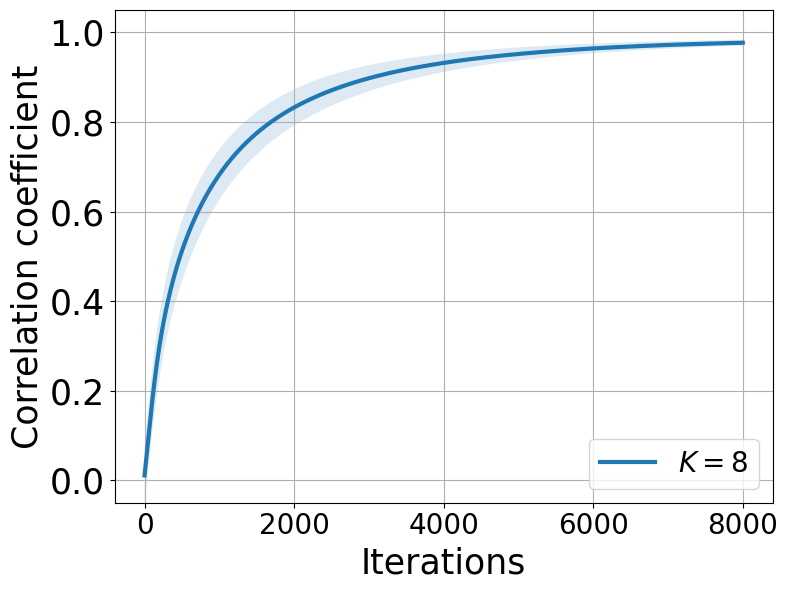



 For data_topic_2 :
Only shows Wmm


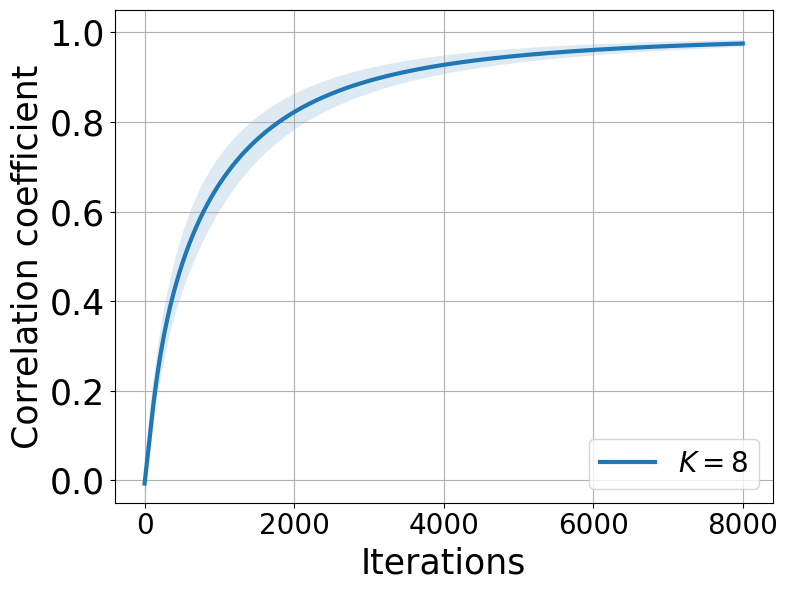



 For data_combine :
Only shows Wmm


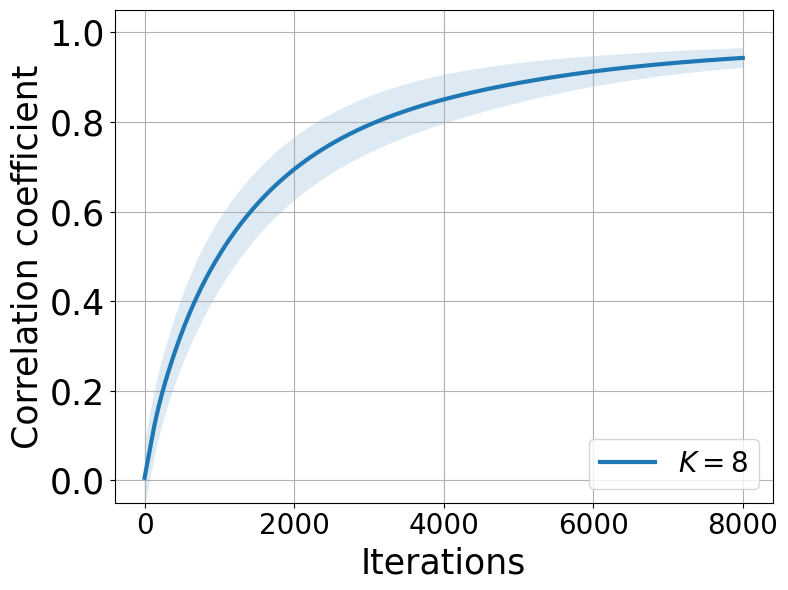

In [ ]:
labels = [
    # r'$W(t)^{onetoken}$',
    r'$W(\tau)^{mm}$',
    r'$W(\tau)$',
]

for data in training_datasets:
    print('\n\n For', data, ':')
    show_corr(ITN, dlist, corr_list_values[data], wmm = True, labels = labels)